# Solar Transformer

In [1]:
!pip install wandb tensorflow_probability tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from tensorflow.keras.layers import Add, Dense, Dropout, Layer, LayerNormalization, MultiHeadAttention, Normalization
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError, MeanAbsoluteError
from tensorflow_addons.metrics import RSquare
from wandb.keras import WandbCallback

import os
import math
import wandb
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
# tf.config.experimental_connect_to_cluster(resolver)
# # This is the TPU initialization code that has to be at the beginning.
# tf.tpu.experimental.initialize_tpu_system(resolver)
# print("All devices: ", tf.config.list_logical_devices('TPU'))
# strategy = tf.distribute.TPUStrategy(resolver)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Plotting

In [5]:
def plot_4d(matrix):
    fig = plt.figure(figsize=(10, 20), dpi=300)
    plt.title("Attention heatmap")

    # create grid
    x = np.arange(0, matrix.shape[0], 1, dtype=np.int32)  # timesteps
    y = np.arange(0, matrix.shape[1], 1, dtype=np.int32)    # patches
    z = np.arange(0, matrix.shape[2], 1, dtype=np.int32)  # timesteps
    X, Y, Z = np.meshgrid(x, y, z)

    X = X.transpose([1, 0, 2])
    Y = Y.transpose([1, 0, 2])
    Z = Z.transpose([1, 0, 2])

    for I in range(matrix.shape[3]):
        # Plot
        ax = plt.subplot(5, 5, I+1, projection="3d")
        ax.scatter3D(X, Y, Z, c=matrix[:, :, :, I], marker='s', s=99, cmap='jet')
        ax.set_title(
            f"{I}-th patch"
        )
        ax.set_xlabel("Timestep")
        ax.set_ylabel("Patch")
        ax.set_zlabel("Timestep")

    plt.show()

## Init logger

In [6]:
wandb.login()

sweep_config = {
  'method': 'random',
  'metric': {
    'goal': 'minimize',
    'name': 'val_mean_squared_error'
  },
  'parameters': {
      'epochs': {
        'values': [50, 100, 150, 200, 300]
      },
      'num_encoder_layers': {
        'values': [1, 2, 3, 4, 5]
      },
      'num_decoder_layers': {
        'values': [1, 2, 3, 4, 5]
      },
      'embed_layer_size': {
        'values': [32, 64, 128, 256, 512]
      },
      'fc_layer_size': {
        'values': [32, 64, 128, 256, 512, 1024]
      },
      'num_heads': {
        'values': [2, 4, 6, 8]
      },
      'dropout': {
        'values': [0.0, 0.1, 0.15, 0.2]
      },
      'attention_dropout': {
        'values': [0.0, 0.1, 0.15, 0.2]
      },
      'optimizer': {
        'values': ['adam', 'adamw']
      },
      'global_clipnorm': {
        'values': [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
      },
      'learning_rate': {
        'values': [6e-3, 5e-3, 4e-3, 3e-3, 2e-3, 1e-3]
      },
      'weight_decay': {
          'values': [5e-4, 2.5e-4, 1e-4, 5e-5, 1e-5, 1e-6, 0.0]
      },
      'warmup_steps': {
        'values': [5, 10, 15, 20, 30]
      },
      'window_size': {
        'values': [7, 14, 21, 28, 35, 42, 49, 56]           # from 1 week to 2 months
      },
      'batch_size': {
        'values': [8, 16, 24, 32]
      },
    }
}


sweep_id = wandb.sweep(sweep_config, project="solar-transformer")

wandb: Currently logged in as: markub. Use `wandb login --relogin` to force relogin


Create sweep with ID: rs17fvv2
Sweep URL: https://wandb.ai/markub/solar-transformer/sweeps/rs17fvv2


## Masking

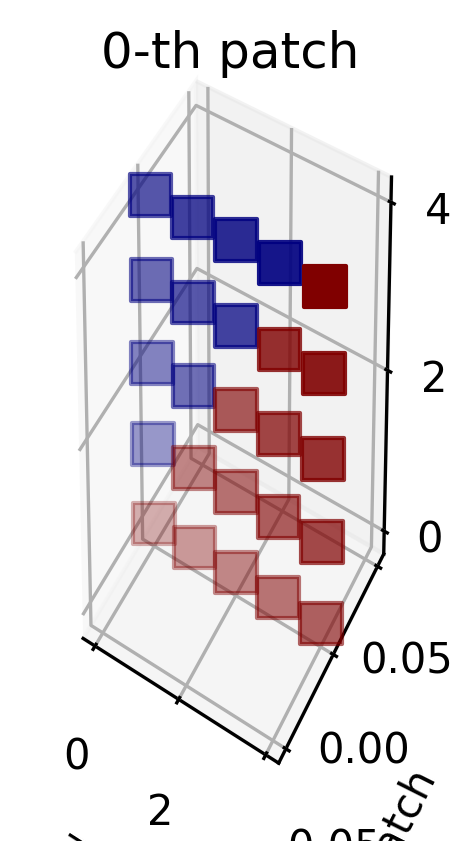

In [7]:
# (Timestep, Patch)
def create_look_ahead_mask(size):
  n = tf.cast((size * (size+1) / 2), dtype=tf.int32)
  mask = tfp.math.fill_triangular(tf.ones((n,), dtype=tf.bool), upper=False)
  mask = mask[:, tf.newaxis, :, tf.newaxis]  # (timestep, 1, timestep, 1)
  return mask

plot_4d(create_look_ahead_mask(5))

## Layer

In [8]:
class PositionalEmbedding(Layer):
    def __init__(self, units, dropout_rate, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)

        self.units = units

        self.projection = Dense(units, kernel_initializer=TruncatedNormal(stddev=0.02))
        self.dropout = Dropout(rate=dropout_rate)

    def build(self, input_shape):
        super(PositionalEmbedding, self).build(input_shape)

        print(input_shape)
        self.temporal_position = self.add_weight(
            name="temporal_position",
            shape=(1, input_shape[1], 1, self.units),
            initializer=TruncatedNormal(stddev=0.02),
            trainable=True,
        )
        self.spatial_position = self.add_weight(
            name="spatial_position",
            shape=(1, 1, input_shape[2], self.units),
            initializer=TruncatedNormal(stddev=0.02),
            trainable=True,
        )

    def call(self, inputs, training):
        seq_len = tf.shape(inputs)[1]

        x = self.projection(inputs)
        x = x + self.temporal_position[:, :seq_len]
        x = x + self.spatial_position

        return self.dropout(x, training=training)

In [9]:
class Encoder(Layer):
    def __init__(
        self, embed_dim, mlp_dim, num_heads, dropout_rate, attention_dropout_rate, **kwargs
    ):
        super(Encoder, self).__init__(**kwargs)

        # Multi-head Attention
        self.mha = MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim,
            dropout=attention_dropout_rate,
            kernel_initializer=TruncatedNormal(stddev=0.02),
            attention_axes=(1, 2),       # 2D attention (timestep, patch)
        )

        # Point wise feed forward network
        self.dense_0 = Dense(
            units=mlp_dim,
            activation="gelu",
            kernel_initializer=TruncatedNormal(stddev=0.02),
        )
        self.dense_1 = Dense(
            units=embed_dim, kernel_initializer=TruncatedNormal(stddev=0.02)
        )

        self.dropout_0 = Dropout(rate=dropout_rate)
        self.dropout_1 = Dropout(rate=dropout_rate)

        self.norm_0 = LayerNormalization(epsilon=1e-5)
        self.norm_1 = LayerNormalization(epsilon=1e-5)

        self.add_0 = Add()
        self.add_1 = Add()

    def call(self, inputs, training):
        # Attention block
        x = self.norm_0(inputs)
        x = self.mha(
            query=x,
            key=x,
            value=x,
            training=training,
        )
        x = self.dropout_0(x, training=training)
        x = self.add_0([x, inputs])

        # MLP block
        y = self.norm_1(x)
        y = self.dense_0(y)
        y = self.dense_1(y)
        y = self.dropout_1(y, training=training)

        return self.add_1([x, y])

In [10]:
class Decoder(Layer):
    def __init__(
        self, embed_dim, mlp_dim, num_heads, dropout_rate, attention_dropout_rate, **kwargs
    ):
        super(Decoder, self).__init__(**kwargs)

        # MultiHeadAttention
        self.mha_0 = MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim,
            dropout=attention_dropout_rate,
            kernel_initializer=TruncatedNormal(stddev=0.02),
            attention_axes=(1, 2),          # 2D attention (timestep, patch)
        )
        self.mha_1 = MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim,
            dropout=attention_dropout_rate,
            kernel_initializer=TruncatedNormal(stddev=0.02),
            attention_axes=(1, 2),          # 2D attention (timestep, patch)
        )

        # Point wise feed forward network
        self.dense_0 = Dense(
            units=mlp_dim,
            activation="gelu",
            kernel_initializer=TruncatedNormal(stddev=0.02),
        )
        self.dense_1 = Dense(
            units=embed_dim, kernel_initializer=TruncatedNormal(stddev=0.02)
        )

        self.dropout_0 = Dropout(rate=dropout_rate)
        self.dropout_1 = Dropout(rate=dropout_rate)
        self.dropout_2 = Dropout(rate=dropout_rate)

        self.norm_0 = LayerNormalization(epsilon=1e-5)
        self.norm_1 = LayerNormalization(epsilon=1e-5)
        self.norm_2 = LayerNormalization(epsilon=1e-5)

        self.add_0 = Add()
        self.add_1 = Add()
        self.add_2 = Add()

    def call(self, inputs, enc_output, training, look_ahead_mask):
        # Attention block
        x = self.norm_0(inputs)
        x = self.mha_0(
            query=x,
            key=x,
            value=x,
            training=training,
            attention_mask=look_ahead_mask,
        )
        x = self.dropout_0(x, training=training)
        x = self.add_0([x, inputs])

        # Attention block
        y = self.norm_1(x)
        y = self.mha_1(
            query=y,
            key=enc_output,
            value=enc_output,
            training=training,
        )
        y = self.dropout_1(y, training=training)
        y = self.add_1([x, y])

        # MLP block
        z = self.norm_2(y)
        z = self.dense_0(z)
        z = self.dense_1(z)
        z = self.dropout_2(z, training=training)

        return self.add_2([y, z])

## Model

### Daily Transformer

In [11]:
class DailyTransformer(Model):
    def __init__(
        self,
        num_encoder_layers,
        num_decoder_layers,
        embed_dim,
        mlp_dim,
        num_heads,
        num_outputs,
        dropout_rate,
        attention_dropout_rate,
        **kwargs
    ):
        super(DailyTransformer, self).__init__(**kwargs)

        # Input (normalization of RAW measurements)
        self.input_norm_enc = Normalization()
        self.input_norm_dec = Normalization()

        # Input
        self.pos_embs_0 = PositionalEmbedding(embed_dim, dropout_rate)
        self.pos_embs_1 = PositionalEmbedding(embed_dim, dropout_rate)

        # Encoder
        self.enc_layers = [
            Encoder(embed_dim, mlp_dim, num_heads, dropout_rate, attention_dropout_rate)
            for _ in range(num_encoder_layers)
        ]
        self.norm_0 = LayerNormalization(epsilon=1e-5)

        # Decoder
        self.dec_layers = [
            Decoder(embed_dim, mlp_dim, num_heads, dropout_rate, attention_dropout_rate)
            for _ in range(num_decoder_layers)
        ]
        self.norm_1 = LayerNormalization(epsilon=1e-5)

        # Output
        self.final_layer = Dense(num_outputs, kernel_initializer=TruncatedNormal(stddev=0.02))

    def call(self, inputs, training):
        inputs, targets = inputs
        look_ahead_mask = create_look_ahead_mask(tf.shape(targets)[1])

        # Encoder input
        x_e = self.input_norm_enc(inputs)
        x_e = self.pos_embs_0(x_e, training=training)

        # Encoder
        for layer in self.enc_layers:
            x_e = layer(x_e, training=training)
        x_e = self.norm_0(x_e)

        # Decoder input
        x_d = self.input_norm_dec(targets)
        x_d = self.pos_embs_1(x_d, training=training)

        # Decoder
        for layer in self.dec_layers:
            x_d = layer(x_d, x_e, training=training, look_ahead_mask=look_ahead_mask)
        x_d = self.norm_1(x_d)

        # Output
        final_output = self.final_layer(x_d)

        return final_output

    def train_step(self, inputs):
        inputs, targets = inputs
        inputs = inputs[:, :-1]
        targets_inputs = targets[:, :-1]
        targets_real = targets[:, 1:]

        with tf.GradientTape() as tape:
            y_pred = self([inputs, targets_inputs], training=True)
            loss = self.compiled_loss(targets_real, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(targets_real, y_pred)

        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, inputs):
        inputs, targets = inputs
        inputs = inputs[:, :-1]
        targets_inputs = targets[:, :-1]
        targets_real = targets[:, 1:]

        # Compute predictions
        y_pred = self([inputs, targets_inputs], training=False)

        # Updates the metrics tracking the loss
        self.compiled_loss(targets_real, y_pred, regularization_losses=self.losses)

        # Update the metrics
        self.compiled_metrics.update_state(targets_real, y_pred)

        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}

### Daily + Hourly Transformer

In [12]:
class Transformer2(Model):
    def __init__(
        self,
        num_encoder_layers,
        num_decoder_layers,
        embed_dim,
        mlp_dim,
        num_heads,
        num_outputs,
        dropout_rate,
        attention_dropout_rate,
        **kwargs
    ):
        super(Transformer, self).__init__(**kwargs)

        # Input (normalization of RAW measurements)
        self.input_norm_enc = Normalization()
        self.input_norm_dec_1 = Normalization()
        self.input_norm_dec_2 = Normalization()

        # Input
        self.pos_embs_0 = PositionalEmbedding(embed_dim, dropout_rate)
        self.pos_embs_1 = PositionalEmbedding(embed_dim, dropout_rate)
        self.pos_embs_2 = PositionalEmbedding(embed_dim, dropout_rate)

        # Encoder - daily
        self.enc_layers = [
            Encoder(embed_dim, mlp_dim, num_heads, dropout_rate, attention_dropout_rate)
            for _ in range(num_encoder_layers)
        ]
        self.norm_0 = LayerNormalization(epsilon=1e-5)

        # Decoder - daily
        self.dec_layers_1 = [
            Decoder(embed_dim, mlp_dim, num_heads, dropout_rate, attention_dropout_rate)
            for _ in range(num_decoder_layers)
        ]
        self.norm_1 = LayerNormalization(epsilon=1e-5)

        # Decoder - hourly
        self.dec_layers_2 = [
            Decoder(embed_dim, mlp_dim, num_heads, dropout_rate, attention_dropout_rate)
            for _ in range(num_decoder_layers)
        ]
        self.norm_2 = LayerNormalization(epsilon=1e-5)

        # Output - daily
        self.final_layer_daily = Dense(num_outputs, kernel_initializer=TruncatedNormal(stddev=0.02))
        self.final_layer_daily_sin = Dense(1, activation=tf.math.sin, kernel_initializer=TruncatedNormal(stddev=0.02))
        self.final_layer_daily_cos = Dense(1, activation=tf.math.cos, kernel_initializer=TruncatedNormal(stddev=0.02))

        # Output - hourly
        self.final_layer_hourly = Dense(num_outputs, kernel_initializer=TruncatedNormal(stddev=0.02))
        self.final_layer_hourly_sin = Dense(2, activation=tf.math.sin, kernel_initializer=TruncatedNormal(stddev=0.02))
        self.final_layer_hourly_cos = Dense(2, activation=tf.math.cos, kernel_initializer=TruncatedNormal(stddev=0.02))

    def call(self, inputs, training):
        inputs, targets_daily, targets_hourly = inputs
        look_ahead_mask_daily, look_ahead_mask_hourly = self.create_masks(targets_daily, targets_hourly)

        # Encoder input
        x_e = self.input_norm_enc(inputs)
        x_e = self.pos_embs_0(x_e, training=training)

        # Decoder - daily input
        x_d_1 = self.input_norm_dec_1(targets_daily)
        x_d_1 = self.pos_embs_1(x_d_1, training=training)

        # Decoder - hourly input
        x_d_2 = self.input_norm_dec_2(targets_hourly)
        x_d_2 = self.pos_embs_2(x_d_2, training=training)

        # Encoder
        for layer in self.enc_layers:
            x_e = layer(x_e, training=training, attention_mask=None)
        x_e = self.norm_0(x_e)

        # Decoder - daily
        for i, layer in enumerate(self.dec_layers_1):
            x_d_1 = layer(x_d_1, x_e, training=training, look_ahead_mask=look_ahead_mask_daily, attention_mask=None)
        x_d_1 = self.norm_1(x_d_1)

        # Decoder - hourly
        for i, layer in enumerate(self.dec_layers_2):
            x_d_2 = layer(x_d_2, x_e, training=training, look_ahead_mask=look_ahead_mask_hourly, attention_mask=None)
        x_d_2 = self.norm_2(x_d_2)

        # Output - daily
        final_output_daily = self.final_layer_daily(x_d_1)
        final_layer_daily_sin = self.final_layer_daily_sin(x_d_1)
        final_layer_daily_cos = self.final_layer_daily_cos(x_d_1)

        # Output - hourly
        final_output_hourly = self.final_layer_hourly(x_d_2)
        final_layer_hourly_sin = self.final_layer_hourly_sin(x_d_2)
        final_layer_hourly_cos = self.final_layer_hourly_cos(x_d_2)

        return (
            tf.concat([final_output_daily, final_layer_daily_sin, final_layer_daily_cos], axis=-1),
            tf.concat([final_output_hourly, final_layer_hourly_sin, final_layer_hourly_cos], axis=-1)
        )

    def train_step(self, inputs):
        inputs, targets_daily, targets_hourly = inputs
        inputs = inputs[:, :-1]
        targets_daily_inputs = targets_daily[:, :-1]
        targets_daily_real = targets_daily[:, 1:]
        targets_hourly_inputs = targets_hourly[:, :-1]
        targets_hourly_real = targets_hourly[:, 1:]

        with tf.GradientTape() as tape:
            y_pred = self([inputs, targets_daily_inputs, targets_hourly_inputs], training=True)
            loss = self.compiled_loss((targets_daily_real, targets_hourly_real), y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state((targets_daily_real, targets_hourly_real), y_pred)

        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, inputs):
        inputs, targets_daily, targets_hourly = inputs
        inputs = inputs[:, :-1]
        targets_daily_inputs = targets_daily[:, :-1]
        targets_daily_real = targets_daily[:, 1:]
        targets_hourly_inputs = targets_hourly[:, :-1]
        targets_hourly_real = targets_hourly[:, 1:]

        # Compute predictions
        y_pred = self([inputs, targets_daily_inputs, targets_hourly_inputs], training=False)

        # Updates the metrics tracking the loss
        self.compiled_loss((targets_daily_real, targets_hourly_real), y_pred, regularization_losses=self.losses)

        # Update the metrics.
        self.compiled_metrics.update_state((targets_daily_real, targets_hourly_real), y_pred)

        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}

    def create_masks(self, targets_daily, targets_hourly):
        # Used in the 1st attention block in the decoder.
        look_ahead_mask_daily = create_look_ahead_mask(tf.shape(targets_daily)[1])

        # Used in the 1st attention block in the decoder.
        look_ahead_mask_hourly = create_look_ahead_mask(tf.shape(targets_hourly)[1])

        return look_ahead_mask_daily, look_ahead_mask_hourly

## LR scheduler

In [13]:
def cosine_schedule(base_lr, total_steps, warmup_steps):
    def step_fn(epoch):
        lr = base_lr
        epoch += 1

        progress = (epoch - warmup_steps) / float(total_steps - warmup_steps)
        progress = tf.clip_by_value(progress, 0.0, 1.0)
        
        lr = lr * 0.5 * (1.0 + tf.cos(math.pi * progress))

        if warmup_steps:
            lr = lr * tf.minimum(1.0, epoch / warmup_steps)

        return lr

    return step_fn

In [14]:
class PrintLR(Callback):
    def on_epoch_end(self, epoch, logs=None):
        wandb.log({"lr": self.model.optimizer.lr.numpy()}, commit=False)

## Daily Dataset

In [15]:
df_X = pd.read_csv("/content/drive/MyDrive/Solar-Transformer/1984_2022/X_all_daily.csv")
df_y_daily = pd.read_csv("/content/drive/MyDrive/Solar-Transformer/1984_2022/y_all_daily.csv")

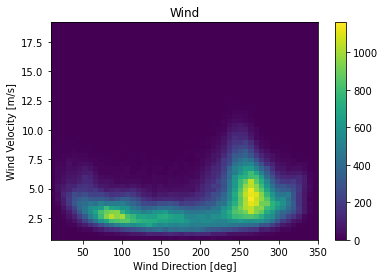

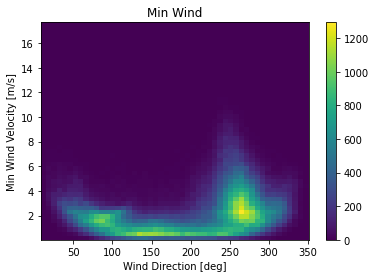

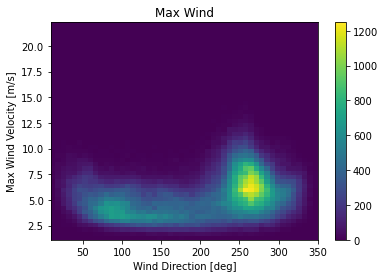

In [16]:
plt.hist2d(df_X['WindDirection1'], df_X['WindSpeed1'], bins=(50, 50))
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')
plt.title("Wind")
plt.show()

plt.hist2d(df_X['WindDirection1'], df_X['WindSpeedMin1'], bins=(50, 50))
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Min Wind Velocity [m/s]')
plt.title("Min Wind")
plt.show()

plt.hist2d(df_X['WindDirection1'], df_X['WindSpeedMax1'], bins=(50, 50))
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Max Wind Velocity [m/s]')
plt.title("Max Wind")
plt.show()

date_time = pd.to_datetime(df_X.pop('DateTime'), format='%Y-%m-%d')
num_of_patches = df_X['Name'].nunique()

df_X = df_X.drop(
    columns=['Name', 'Latitude', 'Longitude', 'Day'] +
            [c for c in df_X.columns if c[:9] == 'WindSpeed'] +
            [c for c in df_X.columns if c[:12] == 'WindSpeedMin'] +
            [c for c in df_X.columns if c[:12] == 'WindSpeedMax'] +
            [c for c in df_X.columns if c[:13] == 'WindDirection']
)
df_y_daily = df_y_daily.drop(
    columns=['DateTime', 'Name', 'Latitude', 'Longitude', 'Day'] +
            [c for c in df_y_daily.columns if c[:9] == 'WindSpeed'] +
            [c for c in df_y_daily.columns if c[:12] == 'WindSpeedMin'] +
            [c for c in df_y_daily.columns if c[:12] == 'WindSpeedMax'] +
            [c for c in df_y_daily.columns if c[:13] == 'WindDirection']
)

In [17]:
print(df_X.head())
for col in df_X.columns:
    print(col)

print(df_y_daily.head())
for col in df_y_daily.columns:
    print(col)

   Irradiance1  Temp1  TempMin1  TempMax1  Humidity1    WindX1    WindY1  \
0         3.76  21.58     16.42     27.40      76.18 -4.228627 -0.107776   
1         4.48  18.77     10.77     28.63      42.56 -1.170039 -2.521787   
2         3.42  25.45     23.90     27.41      86.56  2.799135  5.374797   
3         4.30  21.13     20.48     21.70      58.78 -4.957817  0.469525   
4         4.29  17.24      9.69     25.62      33.27 -3.987793  2.449470   

   WindXMin1  WindYMin1  WindXMax1  ...  TempMin25  TempMax25  Humidity25  \
0  -2.129309  -0.054270  -7.077702  ...      12.17      22.62       72.65   
1  -0.429295  -0.925260  -2.070717  ...      10.67      30.40       41.92   
2   1.819899   3.494505   3.787608  ...      23.24      27.60       83.71   
3  -3.653652   0.346015  -7.775210  ...       8.02      25.35       24.34   
4  -2.760780   1.695787  -5.351141  ...       7.23      26.02       26.48   

    WindX25   WindY25  WindXMin25  WindYMin25  WindXMax25  WindYMax25  \
0 -2.32

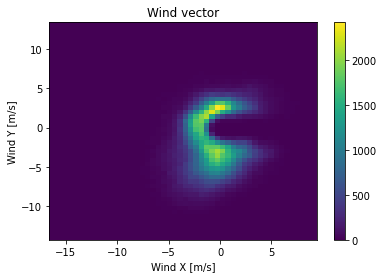

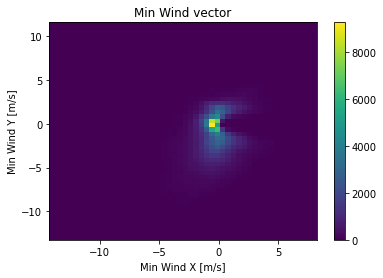

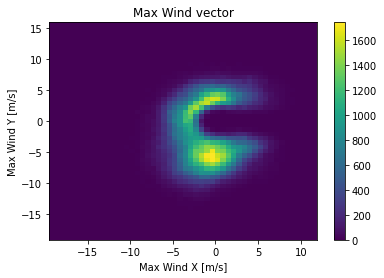

In [18]:
plt.hist2d(df_X['WindX1'], df_X['WindY1'], bins=(50, 50))
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
plt.title("Wind vector")
ax = plt.gca()
ax.axis('tight')
plt.show()

plt.hist2d(df_X['WindXMin1'], df_X['WindYMin1'], bins=(50, 50))
plt.colorbar()
plt.xlabel('Min Wind X [m/s]')
plt.ylabel('Min Wind Y [m/s]')
plt.title("Min Wind vector")
ax = plt.gca()
ax.axis('tight')
plt.show()

plt.hist2d(df_X['WindXMax1'], df_X['WindYMax1'], bins=(50, 50))
plt.colorbar()
plt.xlabel('Max Wind X [m/s]')
plt.ylabel('Max Wind Y [m/s]')
plt.title("Max Wind vector")
ax = plt.gca()
ax.axis('tight')
plt.show()


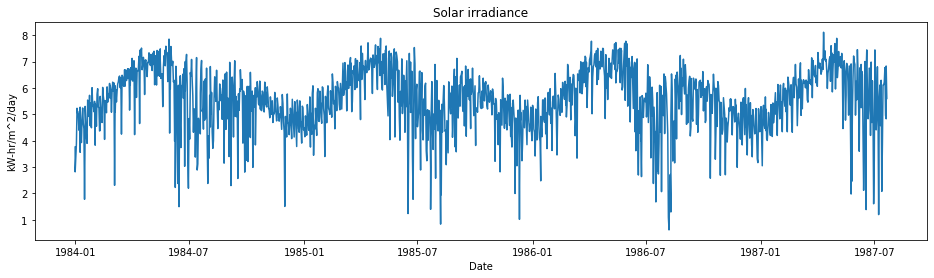

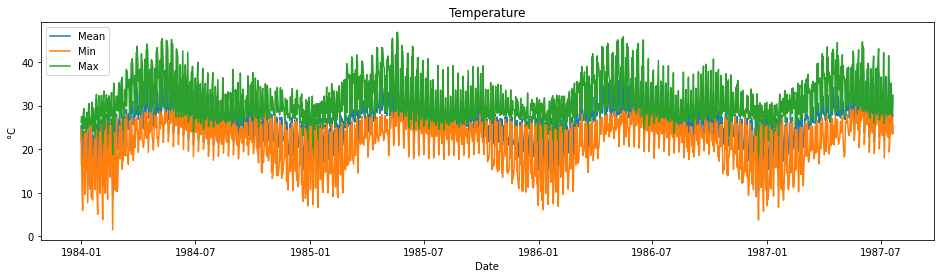

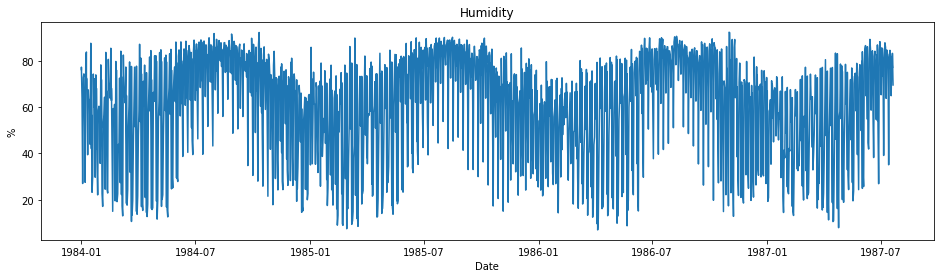

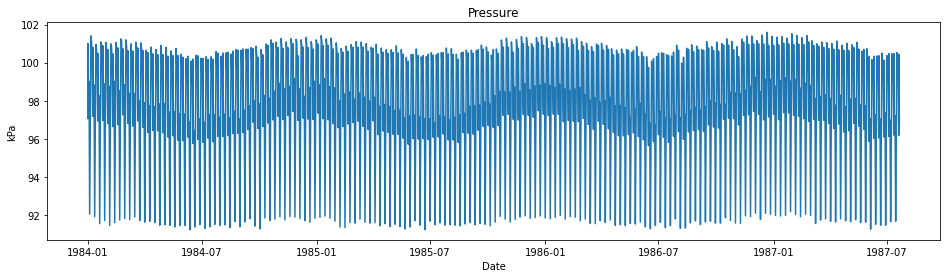

In [19]:
x_data = date_time[:(5856 + 5840 + 5840 + 5840):16]

plt.figure(figsize=(16, 4))
plt.plot(x_data, df_X["Irradiance1"][:(5856 + 5840 + 5840 + 5840):16])
plt.ylabel('kW-hr/m^2/day')
plt.xlabel("Date"),
plt.title("Solar irradiance")
plt.show()

plt.figure(figsize=(16, 4))
plt.plot(x_data, df_X["Temp1"][:(5856 + 5840 + 5840 + 5840):16])
plt.plot(x_data, df_X["TempMin1"][:(5856 + 5840 + 5840 + 5840):16])
plt.plot(x_data, df_X["TempMax1"][:(5856 + 5840 + 5840 + 5840):16])
plt.ylabel('°C')
plt.xlabel("Date"),
plt.title("Temperature")
plt.legend(["Mean", "Min", "Max"])
plt.show()

plt.figure(figsize=(16, 4))
plt.plot(x_data, df_X["Humidity1"][:(5856 + 5840 + 5840 + 5840):16])
plt.ylabel('%')
plt.xlabel("Date"),
plt.title("Humidity")
plt.show()

plt.figure(figsize=(16, 4))
plt.plot(x_data, df_X["Pressure1"][:(5856 + 5840 + 5840 + 5840):16])
plt.ylabel('kPa')
plt.xlabel("Date"),
plt.title("Pressure")
plt.show()

## Dataset

In [20]:
def make_dataset(data, sequence_length, sequence_stride, sampling_rate):
    def make_window(data):
        dataset = tf.data.Dataset.from_tensor_slices(data)
        dataset = dataset.window(sequence_length, shift=sequence_stride, stride=sampling_rate, drop_remainder=True)
        dataset = dataset.flat_map(lambda x: x.batch(sequence_length, drop_remainder=True))        
        return dataset

    data = np.array(data, dtype=np.float32)
    data = np.reshape(data, (-1, num_of_patches, data.shape[-1]))

    # Split the data
    # (75%, 15%, 10%)
    n = data.shape[0]
    train_data = data[0:int(n*0.75)]
    val_data = data[int(n*0.75):int(n*0.9)]
    test_data = data[int(n*0.9):]

    return (
        make_window(train_data),
        make_window(val_data),
        make_window(test_data)
    )

def merge_dataset(datasets, batch_size):
    dataset = tf.data.Dataset.zip(datasets)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    # Shuffle locally at each iteration
    dataset = dataset.shuffle(buffer_size=batch_size * 8)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    
    return dataset

def count_dataset(train_ds, val_ds, test_ds):
    c = 0
    for x in train_ds:
      c += 1
      #print(x[:, :, :6])
    print(c)

    c = 0
    for x in val_ds:
      c += 1
      #print(x[:, :, :6])
    print(c)

    c = 0
    for x in test_ds:
      c += 1
      #print(x[:, :, :6])
    print(c)

## Training loop

In [21]:
def training_loop(cfg):
    # load dataset
    train_X_ds, val_X_ds, _ = make_dataset(df_X, cfg.window_size, 1, 1)
    train_y_daily_ds, val_y_daily_ds, _ = make_dataset(df_y_daily, cfg.window_size, 1, 1)
    #train_y_hourly_ds, val_y_hourly_ds, test_y_hourly_ds = make_dataset(df_y_hourly, (21 * 24), 24, 1)

    #count_dataset(train_X_ds, val_X_ds, test_X_ds)
    #count_dataset(train_y_daily_ds, val_y_daily_ds, test_y_daily_ds)
    #count_dataset(train_y_hourly_ds, val_y_hourly_ds, test_y_hourly_ds)

    train_ds = merge_dataset((train_X_ds, train_y_daily_ds), cfg.batch_size)
    val_ds = merge_dataset((val_X_ds, val_y_daily_ds), cfg.batch_size)

    #with strategy.scope():
    # Generate new model
    daily_model = DailyTransformer(
      num_encoder_layers=cfg.num_encoder_layers,
      num_decoder_layers=cfg.num_decoder_layers,
      embed_dim=cfg.embed_layer_size,
      mlp_dim=cfg.fc_layer_size,
      num_heads=cfg.num_heads,
      num_outputs=1,
      dropout_rate=cfg.dropout,
      attention_dropout_rate=cfg.attention_dropout,
    )

    # adapt on inputs of training dataset - must be before model.compile !!!
    daily_model.input_norm_enc.adapt(train_X_ds)
    print(daily_model.input_norm_enc.variables)

    # adapt on targets of training dataset - must be before model.compile !!!
    daily_model.input_norm_dec.adapt(train_y_daily_ds)
    print(daily_model.input_norm_dec.variables)

    #with strategy.scope():
    # Select optimizer
    if cfg.optimizer == "adam":
      optim = Adam(
          global_clipnorm=cfg.global_clipnorm,
      )
    elif cfg.optimizer == "adamw":
      optim = tfa.optimizers.AdamW(
          weight_decay=cfg.weight_decay,
          global_clipnorm=cfg.global_clipnorm
      )
    else:
     raise ValueError("The used optimizer is not in list of available")

    daily_model.compile(
        optimizer=optim,
        # Anything between 2 and `steps_per_epoch` could help here.
        #steps_per_execution = 50,
        loss="log_cosh",
        #run_eagerly=True,
        metrics=[MeanSquaredError(), RootMeanSquaredError(), MeanAbsoluteError(), RSquare()]
    )

    #steps_per_epoch = 60000 // GLOBAL_BATCH_SIZE
    #validation_steps = 10000 // GLOBAL_BATCH_SIZE

    # Train model
    daily_model.fit(
        train_ds,
        epochs=cfg.epochs,
        #steps_per_epoch=steps_per_epoch,
        validation_data=val_ds,
        #validation_steps=validation_steps,
        callbacks=[
            LearningRateScheduler(cosine_schedule(base_lr=cfg.learning_rate, total_steps=cfg.epochs, warmup_steps=cfg.warmup_steps)),
            PrintLR(),
            WandbCallback(monitor="val_mean_squared_error", mode='min', save_weights_only=True),
            EarlyStopping(monitor="val_mean_squared_error", mode='min', min_delta=0.0001, patience=10),
        ],
        verbose=1
    )

    daily_model.summary()

In [22]:
def run(config=None):
  with wandb.init(config=config):
      config = wandb.config

      # check rules
      if (config.fc_layer_size < config.embed_layer_size):
          return
      elif (config.weight_decay > 0.0 and config.optimizer == "adam"):
          return
      elif (config.weight_decay == 0.0 and config.optimizer == "adamw"):
          return
 
      training_loop(config)

In [ ]:
wandb.agent(sweep_id, run, count=1024)
#wandb.agent("solar-transformer/itlmziu0", run, count=1024)

wandb: Agent Starting Run: vziht0gj with config:
wandb: 	attention_dropout: 0.1
wandb: 	batch_size: 24
wandb: 	dropout: 0.1
wandb: 	embed_layer_size: 128
wandb: 	epochs: 300
wandb: 	fc_layer_size: 64
wandb: 	global_clipnorm: 6
wandb: 	learning_rate: 0.005
wandb: 	num_decoder_layers: 4
wandb: 	num_encoder_layers: 3
wandb: 	num_heads: 4
wandb: 	optimizer: adam
wandb: 	warmup_steps: 15
wandb: 	weight_decay: 0.00025
wandb: 	window_size: 21


wandb: Agent Starting Run: tr2foozs with config:
wandb: 	attention_dropout: 0.2
wandb: 	batch_size: 16
wandb: 	dropout: 0.1
wandb: 	embed_layer_size: 64
wandb: 	epochs: 100
wandb: 	fc_layer_size: 32
wandb: 	global_clipnorm: 5
wandb: 	learning_rate: 0.002
wandb: 	num_decoder_layers: 4
wandb: 	num_encoder_layers: 5
wandb: 	num_heads: 2
wandb: 	optimizer: adam
wandb: 	warmup_steps: 30
wandb: 	weight_decay: 0.0001
wandb: 	window_size: 7


wandb: Agent Starting Run: 7wn2ti0e with config:
wandb: 	attention_dropout: 0
wandb: 	batch_size: 32
wandb: 	dropout: 0
wandb: 	embed_layer_size: 128
wandb: 	epochs: 150
wandb: 	fc_layer_size: 32
wandb: 	global_clipnorm: 5
wandb: 	learning_rate: 0.003
wandb: 	num_decoder_layers: 1
wandb: 	num_encoder_layers: 1
wandb: 	num_heads: 8
wandb: 	optimizer: adamw
wandb: 	warmup_steps: 10
wandb: 	weight_decay: 1e-06
wandb: 	window_size: 35


wandb: Agent Starting Run: uicec83p with config:
wandb: 	attention_dropout: 0.1
wandb: 	batch_size: 16
wandb: 	dropout: 0.2
wandb: 	embed_layer_size: 64
wandb: 	epochs: 300
wandb: 	fc_layer_size: 512
wandb: 	global_clipnorm: 4
wandb: 	learning_rate: 0.002
wandb: 	num_decoder_layers: 2
wandb: 	num_encoder_layers: 5
wandb: 	num_heads: 6
wandb: 	optimizer: adamw
wandb: 	warmup_steps: 10
wandb: 	weight_decay: 0
wandb: 	window_size: 21


wandb: Agent Starting Run: bkh8ojlv with config:
wandb: 	attention_dropout: 0.2
wandb: 	batch_size: 8
wandb: 	dropout: 0.2
wandb: 	embed_layer_size: 512
wandb: 	epochs: 300
wandb: 	fc_layer_size: 512
wandb: 	global_clipnorm: 5
wandb: 	learning_rate: 0.004
wandb: 	num_decoder_layers: 5
wandb: 	num_encoder_layers: 3
wandb: 	num_heads: 4
wandb: 	optimizer: adam
wandb: 	warmup_steps: 10
wandb: 	weight_decay: 0
wandb: 	window_size: 56


[<tf.Variable 'mean:0' shape=(300,) dtype=float32, numpy=
array([ 5.354487  , 26.265518  , 21.25585   , 31.891481  , 59.26075   ,
       -0.6109143 , -1.5951757 , -0.27366418, -1.1319457 , -0.9374947 ,
       -2.0870209 , 97.64026   ,  5.3427615 , 26.189129  , 20.989508  ,
       32.015007  , 58.765785  , -0.66188157, -1.4768183 , -0.30108958,
       -1.0298479 , -0.99737287, -1.9634405 , 97.412704  ,  5.349029  ,
       26.20299   , 20.79306   , 32.254223  , 57.92972   , -0.71305794,
       -1.3855779 , -0.32132098, -0.93918186, -1.0750743 , -1.8663293 ,
       97.28115   ,  5.3395953 , 26.180103  , 20.594841  , 32.428547  ,
       57.40177   , -0.7321749 , -1.2393003 , -0.330184  , -0.8160245 ,
       -1.1162022 , -1.7007936 , 97.13129   ,  5.3238487 , 26.095638  ,
       20.418913  , 32.443817  , 57.035435  , -0.75524485, -1.1911633 ,
       -0.35218698, -0.7801314 , -1.1448717 , -1.6514841 , 96.88734   ,
        5.337494  , 26.289232  , 20.999025  , 32.22689   , 57.702435  ,
      

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


[<tf.Variable 'mean:0' shape=(1,) dtype=float32, numpy=array([5.3153706], dtype=float32)>, <tf.Variable 'variance:0' shape=(1,) dtype=float32, numpy=array([1.7599126], dtype=float32)>, <tf.Variable 'count:0' shape=() dtype=int64, numpy=10465056>]
Epoch 1/300
(8, 55, 18, 300)
(8, 55, 18, 1)
1297/1297 [==============================] - 1630s 1s/step - loss: 0.2697 - mean_squared_error: 0.9988 - root_mean_squared_error: 0.9994 - mean_absolute_error: 0.5844 - r_square: 0.4153 - val_loss: 0.2121 - val_mean_squared_error: 0.5868 - val_root_mean_squared_error: 0.7661 - val_mean_absolute_error: 0.5151 - val_r_square: 0.6468 - lr: 4.0000e-04 - _timestamp: 1656785789.0000 - _runtime: 1671.0000
Epoch 2/300
 903/1297 [===================>..........] - ETA: 7:38 - loss: 0.2323 - mean_squared_error: 0.6748 - root_mean_squared_error: 0.8215 - mean_absolute_error: 0.5406 - r_square: 0.6090